In [3]:
import random
import math
import csv
import time
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
from functools import partial
from itertools import product
from sphere_sim_methods import real_space_profile
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


### Import k-space data

In [4]:
numexpr=400
noise=0.001
csv_path=f"./data/train_data{numexpr}_noise{noise}_d6.csv"
complete_df = pd.read_csv(csv_path,index_col=0)

In [5]:
complete_df.head()

,kpoint-127.0,kpoint-126.0,kpoint-125.0,kpoint-124.0,kpoint-123.0,kpoint-122.0,kpoint-121.0,kpoint-120.0,kpoint-119.0,kpoint-118.0,...,kpoint-7.0,kpoint-6.0,kpoint-5.0,kpoint-4.0,kpoint-3.0,kpoint-2.0,kpoint-1.0,kpoint0.0,mean,sd
0,0.944322,1.261497,2.403476,0.337644,0.704067,0.834447,1.673078,0.210288,0.239649,0.305337,...,19.434372,5.975902,7.393580,7.827333,14.401979,8.448032,8.936488,9.578615,6.0,0.0
1,1.407254,1.184237,1.037815,0.179409,1.313070,0.150197,0.387615,1.695056,1.502170,0.267091,...,12.972798,13.780932,10.103895,1.101817,6.353245,5.048992,3.950132,17.593998,6.0,0.0
2,0.462214,1.779045,0.324630,0.688532,0.636184,1.963166,1.544025,0.338164,0.344524,0.045401,...,11.550233,8.717138,8.816666,7.869743,10.681198,19.471695,6.132563,7.418099,6.0,0.0
3,2.661280,0.410125,1.391283,0.353241,0.879832,0.919303,0.972227,0.999540,1.229230,1.635670,...,7.036743,14.775171,13.586719,5.344047,12.937113,4.875012,15.020617,12.246514,6.0,0.0
4,0.433246,0.706709,1.277239,0.270108,0.676813,1.278851,0.354904,0.621867,1.432966,1.057695,...,4.237624,5.856168,9.604865,2.147396,5.535332,10.871491,7.766307,10.935213,6.0,0.0


### Calculate average signal intensity for each k-space point

In [6]:

avg_df=pd.DataFrame(complete_df.mean(axis=0)).transpose()
avg_df=avg_df.drop(columns=['mean','sd'])
avg_df=avg_df.transpose().reset_index().rename(columns={'index':'k-space',0:'signal'})
avg_df['k-space']=avg_df['k-space'].str.slice(7,-2)
avg_df['k-space'] = avg_df['k-space'].replace('',0)
avg_df['k-space']= avg_df['k-space'].astype(int).apply(lambda x: -int(x) if int(x)>0 else 0)
avg_df

,k-space,signal
0,-127,0.936633
1,-126,1.000735
2,-125,0.964180
3,-124,0.989444
4,-123,0.992855
...,...,...
123,-4,9.107703
124,-3,9.320025
125,-2,9.924684
126,-1,9.408801


### Extract a single row(single simulated experiment)

In [7]:
row_nm=90
single_row=complete_df.iloc[[row_nm]]
# Save mean D and SD as seperate parameters and drop them from df
distr=single_row[['mean','sd']]
single_row=single_row.drop(columns=['mean','sd'])

# Transpose df so that k-space points are a new row and signal is a row as well
single_df=pd.DataFrame()
single_df=single_row.transpose().reset_index().rename(columns={'index':'k-space',row_nm:'signal'})

#Slice k-space row to remove letters and save only k-space points from negative to zero
single_df['k-space']=single_df['k-space'].str.slice(7,-2)
single_df['k-space'] = single_df['k-space'].replace('',0)
single_df['k-space']= single_df['k-space'].astype(int).apply(lambda x: -int(x) if int(x)>0 else 0)
single_df

,k-space,signal
0,-127,0.689785
1,-126,0.714742
2,-125,1.256944
3,-124,2.485925
4,-123,0.845515
...,...,...
123,-4,8.813514
124,-3,3.017730
125,-2,9.819383
126,-1,10.980314


In [8]:
distr["mean"].iloc[0]

6.0

### Plot real space and k-space data

In [9]:
#Calculate rolling average of the single experiment data in case this is needed
single_df['rolling_avg'] = single_df['signal'].rolling(window=2).mean().shift(-1)
single_df['rolling_avg']

0       0.702264
1       0.985843
2       1.871435
3       1.665720
4       1.219118
         ...    
123     5.915622
124     6.418556
125    10.399848
126    10.721570
127          NaN
Name: rolling_avg, Length: 128, dtype: float64

###  Plot single experiment k-space signal and average signal of multiple experiments

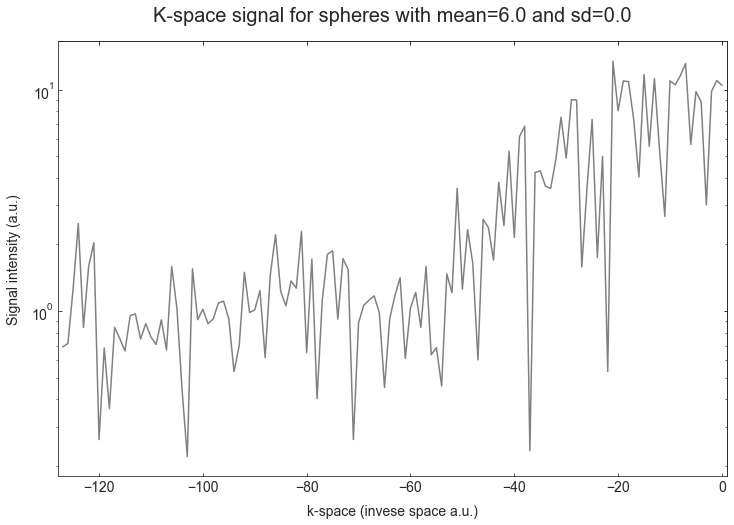

In [10]:
#Define plot parameters

sns.set_style("ticks", {"xtick.major.size": 200, "ytick.major.size": 1})

fig, ax = plt.subplots(figsize=(12,8))



#Change tick mark labels font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#Create actual seborn graph
graph=sns.lineplot(data=single_df, x="k-space", y='signal',color='grey')#, fit_reg=False
#graph_avg=sns.lineplot(data=avg_df, x="k-space", y='signal',color='black', linestyle='--')#, fit_reg=False

#Change axis labels
plt.xlabel("k-space (invese space a.u.)",fontsize=14, labelpad=10)
plt.ylabel("Signal intensity (a.u.)",fontsize=14, labelpad=10)
title="K-space signal for spheres with mean="+str(distr["mean"].iloc[0])+" and sd="+str(distr["sd"].iloc[0])
plt.title(title, size=20, pad=20)

# control x and y limits
plt.xlim(-128,1)
ax.set( yscale="log")

#set tickmarks direction
plt.tick_params(direction="in")

#specify secondary axis similar to primary repeat all that we did above
#Xaxis first
secax = ax.secondary_xaxis('top')
secax.set_xlim([-128, 1])
secax.tick_params(axis="both",direction="in",which="both", pad=10, colors='black')
secax.set_xticklabels([]);

#Yaxis second
secax2 = ax.secondary_yaxis('right')
secax2.tick_params(axis="both",direction="in",which="both", pad=10, colors='black')
secax2.set_yticklabels([]);

plt.savefig("figures/K-space signal for spheres with mean="+str(int(distr["mean"].iloc[0])), bbox_inches='tight')

###  Plot real space signal for same sample as k-space signal

In [11]:

real_df=real_space_profile(diam=distr["mean"].iloc[0],sd=distr["sd"].iloc[0],sphere_num=150)

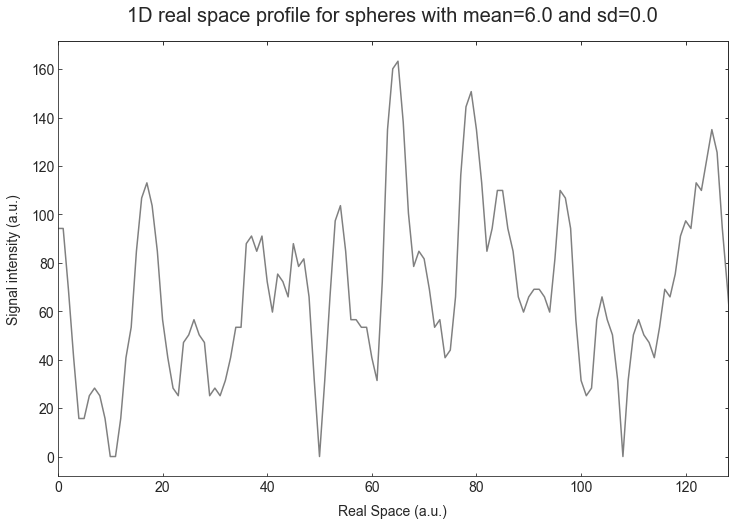

In [12]:
sns.set_style("ticks", {"xtick.major.size": 200, "ytick.major.size": 1})

fig, ax = plt.subplots(figsize=(12,8))



#Change tick mark labels font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#Create actual seborn graph
graph=sns.lineplot(data=real_df, x="space", y='signal',color='grey')#, fit_reg=False


#Change axis labels
plt.xlabel("Real Space (a.u.)",fontsize=14, labelpad=10)
plt.ylabel("Signal intensity (a.u.)",fontsize=14, labelpad=10)
title="1D real space profile for spheres with mean="+str(distr["mean"].iloc[0])+" and sd="+str(distr["sd"].iloc[0])
plt.title(title, size=20, pad=20)

# control x and y limits
plt.xlim(0,128)

#set tickmarks direction
plt.tick_params(direction="in")

#specify secondary axis similar to primary repeat all that we did above
#Xaxis first
secax = ax.secondary_xaxis('top')
secax.set_xlim([0, 128])
secax.tick_params(axis="both",direction="in",which="both", pad=10, colors='black')
secax.set_xticklabels([]);

#Yaxis second
secax2 = ax.secondary_yaxis('right')
secax2.tick_params(axis="both",direction="in",which="both", pad=10, colors='black')
secax2.set_yticklabels([]);

plt.savefig("figures/1D real space profile for spheres with mean="+str(int(distr["mean"].iloc[0])), bbox_inches='tight')